In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

![res](res/2.jpg)

# Phân tích

- Các đổi tượng cần tìm đều ở bên phải của ảnh, có nền trắng. 

    => Có thể tách các đối tượng khỏi nền:
    - Chuyển ảnh từ không gian màu BGR sang không gian màu HSV (cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
    - Lấy mẫu nền bằng cách cắt ảnh
    - Tính toán trung bình và độ lệch chuẩn của h, s, v (mean(), std()) => Xác định ngưỡng dựa trên giá trị trung bình và độ lệch chuẩn (mean - std, mean + std)
    - Tạo mask vùng màu nền (cv2.inRange()), đảo ngược mask để lấy vùng đối tượng (cv2.bitwwise_not())
    - Lấy tất cả countours trên ảnh (cv2.findContours())
    - Giới hạn diện tích để lọc ra các đối tượng. (sử dụng cv2.contourArea() để lấy diện tích của contour)
    - Từ các contour thu được, lấy boudingbox (cv2.boundingRect) và cắt ảnh ra thành các templates.


- Sử dụng Template Matching trên ảnh xám để tìm kiếm
    - Thay đổi kích thước (sử dụng cv2.resize()), góc quay (viết hàm rotate_image(), trả về đối tượng nguyên vẹn sau khi xoay) để tăng khả năng tìm thấy
    - Sử dụng 3 vòng for cho templates, góc xoay, kích thước.
    - template matching (cv2.matchTemplate())
    - Lọc kết quả trả về mà giá trị lớn hơn ngưỡng (np.where())
    - Viết hàm check_intersection() trả về kết quả 2 boudingbox có giao nhau x% hay không. Từ đó lược bỏ những kết quả trả về bị trùng đối tượng

# Tìm

## Đọc ảnh

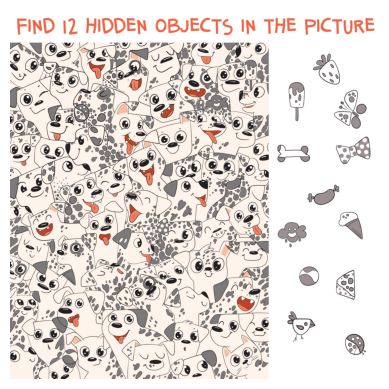

In [2]:
origin_image = cv2.imread('res/2.jpg')
image = origin_image.copy()

plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Tiền xử lý ảnh

### Lọc nhiễu

Sau khi thử lọc nhiễu bằng bộ lọc Gaussian, bộ lọc Morphological,...

Cách tốt nhất là sử dụng bộ lọc trung vị để khử nhiễu, giảm được nhiễu hạt, không làm mờ ảnh và giữ được tối đa những chi tiết nhỏ.



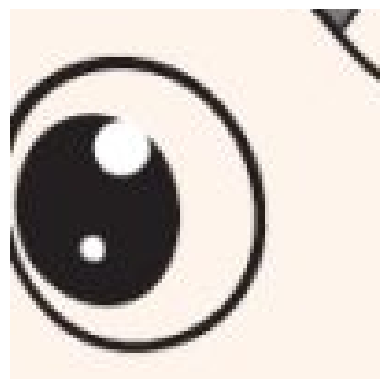

In [3]:
# Ảnh trước khi lọc
x, y, w, h = 0, 2350, 100, 100
zimage = image[y:y+h, x:x+w]

plt.axis('off')
plt.imshow(cv2.cvtColor(zimage, cv2.COLOR_BGR2RGB))

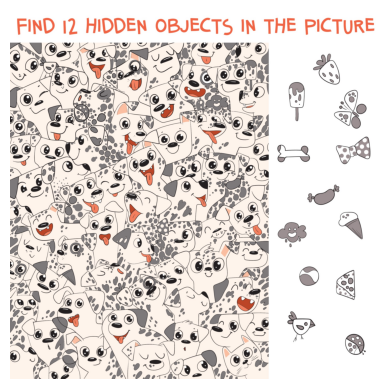

In [4]:
# Lọc nhiễu ảnh bằng cách lọc trung vị
image = cv2.medianBlur(image, 3)

plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

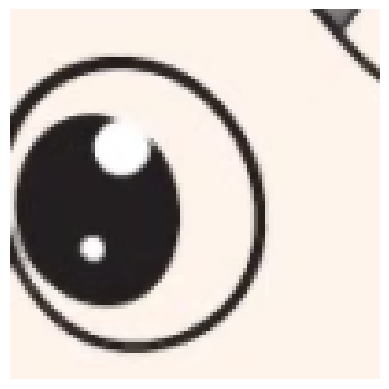

In [5]:
# Kết quả sau khi lọc
x, y, w, h = 0, 2350, 100, 100
zimage = image[y:y+h, x:x+w]

plt.axis('off')
plt.imshow(cv2.cvtColor(zimage, cv2.COLOR_BGR2RGB))

### Tách các vật thể cần tìm

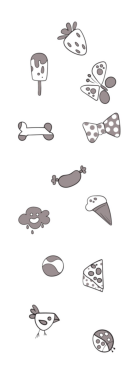

In [6]:
# Cắt phần ảnh chứa đối tượng cần tìm và chuyển đổi sang không gian màu HSV
imagez = image[230:,1800:]
hsv_imagez = cv2.cvtColor(imagez, cv2.COLOR_BGR2HSV)

plt.axis('off')
plt.imshow(cv2.cvtColor(imagez, cv2.COLOR_BGR2RGB))

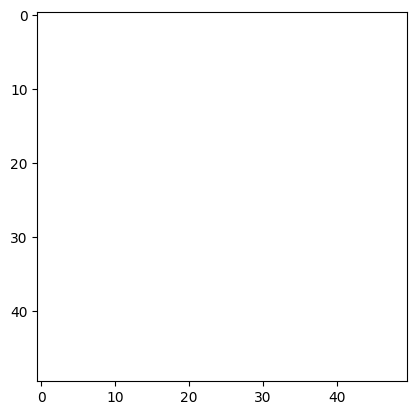

In [7]:
# Chọn một vùng mẫu để tính toán ngưỡng màu nền
x, y, w, h = 0, 0, 50, 50
template = hsv_imagez[y:y+h, x:x+w]

plt.imshow(cv2.cvtColor(template, cv2.COLOR_HSV2RGB))

In [8]:
# Tính toán trung bình và độ lệch chuẩn của h, s, v. Từ đó xác định ngưỡng của màu nền
h_mean, s_mean, v_mean = template[:, :, 0].mean(), template[:, :, 1].mean(), template[:, :, 2].mean()
h_std, s_std, v_std = template[:, :, 0].std(), template[:, :, 1].std(), template[:, :, 2].std()
lower_bound = np.array([max(0, h_mean - h_std), max(0, s_mean - s_std), max(0, v_mean - v_std)])
upper_bound = np.array([min(179, h_mean + h_std), min(255, s_mean + s_std), min(255, v_mean + v_std)])

print(h_mean, s_mean, v_mean)
print(h_std, s_std, v_std)

0.0 0.0 255.0
0.0 0.0 0.0


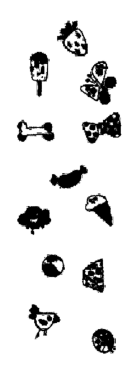

In [9]:
lower_bound = np.array([max(0, h_mean - h_std), max(0, s_mean - s_std), max(0, v_mean - v_std)])
upper_bound = np.array([min(179, h_mean + h_std), min(255, s_mean + s_std), min(255, v_mean + v_std)])

# Tạo mask cho vùng màu nền
mask = cv2.inRange(hsv_imagez, lower_bound, upper_bound)

plt.axis('off')
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

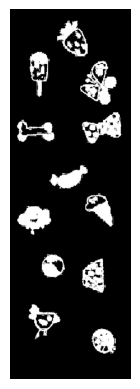

In [10]:
# Đảo ngược mask để lấy vùng đối tượng
mask_inv = cv2.bitwise_not(mask)

plt.axis('off')
plt.imshow(cv2.cvtColor(mask_inv, cv2.COLOR_BGR2RGB))

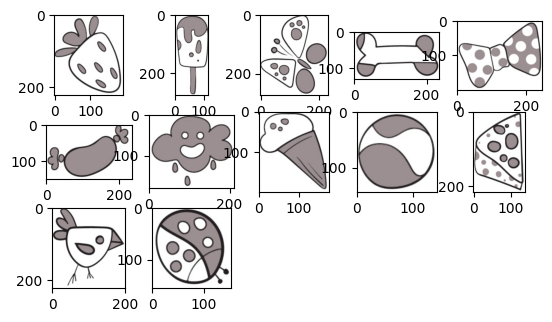

In [11]:
# Tìm các đối tượng trong ảnh bằng cách tìm các contour trong mask đảo ngược
# Giới hạn kích thước của các contour để lọc được các đối tượng cần lấy
size_range = (1000, 50000)
_contours, _ = cv2.findContours(mask_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = [cnt for cnt in _contours if size_range[0] < cv2.contourArea(cnt) < size_range[1]]

# Lưu bouding box của các contour cùng ví trí vào danh sách templates
templates = []
for i, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)
    obj = imagez[y:y+h, x:x+w] 
    templates.append((obj, (x, y, w, h)))

# Chia ảnh thành các hàng và cột để sắp xếp các template.
# Sắp xếp theo thứ tự từ trái sang phải, từ trên xuống dưới
_row, _col = 8, 2
imagez_height, imagez_width = imagez.shape[:2]
templates = sorted(templates, key=lambda x: ((x[1][1] + x[1][3]/2) * _row // imagez_height * _col + (x[1][0] + x[1][2]/2) * _col // imagez_width))
templates = [t[0] for t in templates]

for i in range(len(templates)):
    plt.subplot(4, 5, i + 1)
    plt.imshow(cv2.cvtColor(templates[i], cv2.COLOR_BGR2RGB))
    # plt.axis("off")

### Chuyển ảnh về dạng ảnh xám

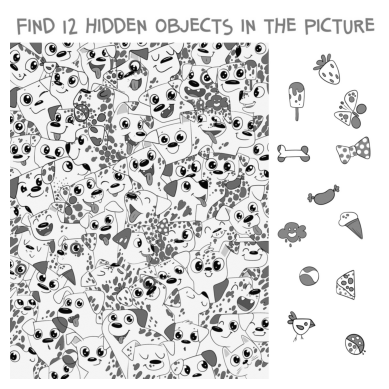

In [12]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.axis('off')
plt.imshow(image, cmap='gray')

In [13]:
# Chuyển các template sang không gian màu xám
templates = [cv2.cvtColor(template, cv2.COLOR_BGR2GRAY) for template in templates]

# Đặt ngưỡng cho từng template
thresholds = [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]

## Template matching

In [14]:
def check_intersection(x1, y1, w1, h1, x2, y2, w2, h2, threshold=0.5):
    """
    Hàm kiểm tra xem hai bounding box có giao nhau hay không
    - threshold: Tỉ lệ giao nhau tối thiểu để coi là trùng lặp
    """
    x_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    y_overlap = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))

    intersection_area = x_overlap * y_overlap
    area1 = w1 * h1
    area2 = w2 * h2

    if intersection_area >= threshold * min(area1, area2):
        return True
    return False

In [15]:
def rotate_image(image, angle, borderValue=(255, 255, 255)):
    """Hàm xoay ảnh theo một góc nhất định"""
    h, w = image.shape[:2] 
    center = (w // 2, h // 2) 

    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int(h * sin + w * cos)
    new_h = int(h * cos + w * sin)

    M[0, 2] += (new_w - w) / 2
    M[1, 2] += (new_h - h) / 2

    rotated = cv2.warpAffine(image, M, (new_w, new_h), borderValue=borderValue)
    return rotated

In [16]:
def matchTemplate(image, templates, thresholds, scales = [1], angles = [0]):
    """Hàm tìm kiếm các đối tượng trong ảnh bằng cách so khớp mẫu"""
    locations = []
    indexes = []
    scales.sort(reverse=True)

    for i, template in enumerate(templates):
        for angle in angles:
            rotated_template = rotate_image(template, angle)
            for scale in scales:
                resized_template = cv2.resize(rotated_template, (0, 0), fx=scale, fy=scale)
                w, h = resized_template.shape[::-1]
                if w > image.shape[1] or h > image.shape[0]:
                    continue

                result = cv2.matchTemplate(image, resized_template, cv2.TM_CCOEFF_NORMED)
                
                # Lấy các vị trí mà giá trị lớn hơn ngưỡng
                temp = np.where(result >= thresholds[i])

                # Lặp qua các vị trí tìm được
                for x, y in zip(*temp[::-1]):
                    add = True
                    for location in locations[::-1]:
                        # Nếu bounding box mới giao với bounding box đã có thì không thêm vào
                        if check_intersection(x, y, w, h, location[0], location[1], location[2], location[3]):
                            add = False
                            break
                    if add:
                        locations.append((x, y, w, h))
                        indexes.append(i)

    return locations, indexes

In [17]:
def drawBoundingBox(image, locations, indexes):
    """Hàm vẽ bounding box cho các đối tượng phát hiện được"""
    image_detected = image.copy()
    for i, (x, y, w, h) in enumerate(locations):
        cv2.rectangle(image_detected, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image_detected, str(indexes[i] + 1), (x + w // 10, y + h),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)
    plt.imshow(cv2.cvtColor(image_detected, cv2.COLOR_BGR2RGB))
    return image_detected

True

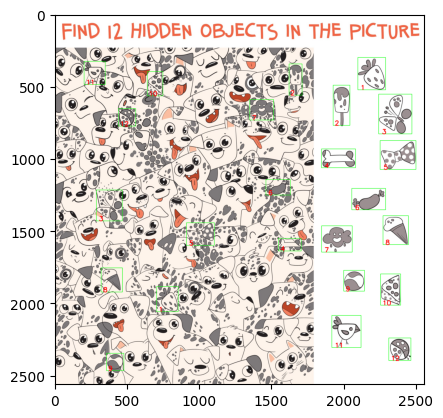

In [18]:
locations, indexes = matchTemplate(image, templates, thresholds, scales= list(np.linspace(0.5, 1, 10)), angles=[0])
image_detected = drawBoundingBox(origin_image, locations, indexes)
cv2.imwrite("result/r2.jpg", image_detected)

## Kết quả

![result](result/r2.jpg)

## Toàn bộ code

True

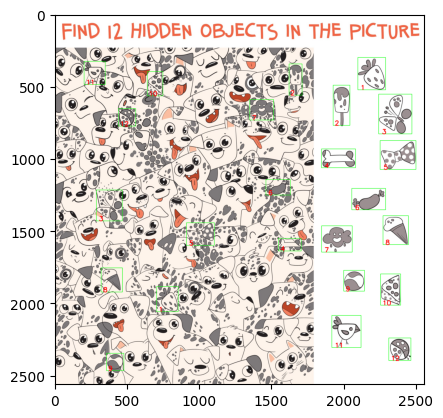

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def check_intersection(x1, y1, w1, h1, x2, y2, w2, h2, threshold=0.5):
    """
    Hàm kiểm tra xem hai bounding box có giao nhau hay không
    - threshold: Tỉ lệ giao nhau tối thiểu để coi là trùng lặp
    """
    x_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    y_overlap = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))

    intersection_area = x_overlap * y_overlap
    area1 = w1 * h1
    area2 = w2 * h2

    if intersection_area >= threshold * min(area1, area2):
        return True
    return False

def rotate_image(image, angle, borderValue=(255, 255, 255)):
    """Hàm xoay ảnh theo một góc nhất định"""
    h, w = image.shape[:2] 
    center = (w // 2, h // 2) 

    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int(h * sin + w * cos)
    new_h = int(h * cos + w * sin)

    M[0, 2] += (new_w - w) / 2
    M[1, 2] += (new_h - h) / 2

    rotated = cv2.warpAffine(image, M, (new_w, new_h), borderValue=borderValue)
    return rotated

def matchTemplate(image, templates, thresholds, scales = [1], angles = [0]):
    """Hàm tìm kiếm các đối tượng trong ảnh bằng cách so khớp mẫu"""
    locations = []
    indexes = []
    scales.sort(reverse=True)

    for i, template in enumerate(templates):
        for angle in angles:
            rotated_template = rotate_image(template, angle)
            for scale in scales:
                resized_template = cv2.resize(rotated_template, (0, 0), fx=scale, fy=scale)
                w, h = resized_template.shape[::-1]
                if w > image.shape[1] or h > image.shape[0]:
                    continue

                result = cv2.matchTemplate(image, resized_template, cv2.TM_CCOEFF_NORMED)

                # Lấy các vị trí mà giá trị lớn hơn ngưỡng
                temp = np.where(result >= thresholds[i])

                # Lặp qua các vị trí tìm được
                for x, y in zip(*temp[::-1]):
                    add = True
                    for location in locations[::-1]:
                        # Kiểm tra xem bounding box mới có giao với các bounding box đã tìm được không
                        if check_intersection(x, y, w, h, location[0], location[1], location[2], location[3]):
                            add = False
                            break
                    if add:
                        locations.append((x, y, w, h))
                        indexes.append(i)

    return locations, indexes

def drawBoundingBox(image, locations, indexes):
    """Hàm vẽ bounding box cho các đối tượng phát hiện được"""
    image_detected = image.copy()
    for i, (x, y, w, h) in enumerate(locations):
        cv2.rectangle(image_detected, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image_detected, str(indexes[i] + 1), (x + w // 10, y + h),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)
    plt.imshow(cv2.cvtColor(image_detected, cv2.COLOR_BGR2RGB))
    return image_detected

# Đọc ảnh và xử lý nhiễu bằng lọc trung vị
origin_image = cv2.imread('res/2.jpg')
image = origin_image.copy()
image = cv2.medianBlur(image, 3)

# Cắt phần ảnh chứa đối tượng cần tìm và chuyển đổi sang không gian màu HSV
imagez = image[230:,1800:]
hsv_imagez = cv2.cvtColor(imagez, cv2.COLOR_BGR2HSV)

# Chọn một vùng mẫu để tính toán ngưỡng màu nền
x, y, w, h = 0, 0, 50, 50
template = hsv_imagez[y:y+h, x:x+w]

# Tính toán trung bình và độ lệch chuẩn của h, s, v. Từ đó xác định ngưỡng của màu nền
h_mean, s_mean, v_mean = template[:, :, 0].mean(), template[:, :, 1].mean(), template[:, :, 2].mean()
h_std, s_std, v_std = template[:, :, 0].std(), template[:, :, 1].std(), template[:, :, 2].std()
lower_bound = np.array([max(0, h_mean - h_std), max(0, s_mean - s_std), max(0, v_mean - v_std)])
upper_bound = np.array([min(179, h_mean + h_std), min(255, s_mean + s_std), min(255, v_mean + v_std)])

# Tạo mask cho vùng màu nền và đảo ngược mask để lấy vùng đối tượng
mask = cv2.inRange(hsv_imagez, lower_bound, upper_bound)
mask_inv = cv2.bitwise_not(mask)

# Tìm các đối tượng trong ảnh bằng cách tìm các contour trong mask đảo ngược
# Giới hạn kích thước của các contour để lọc được các đối tượng cần lấy
size_range = (1000, 50000)
_contours, _ = cv2.findContours(mask_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = [cnt for cnt in _contours if size_range[0] < cv2.contourArea(cnt) < size_range[1]]

# Lưu bouding box của các contour cùng vị trí vào danh sách templates
templates = []
for i, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)
    obj = imagez[y:y+h, x:x+w] 
    templates.append((obj, (x, y, w, h)))

# Chia ảnh thành các hàng và cột để sắp xếp các template.
# Sắp xếp theo thứ tự từ trái sang phải, từ trên xuống dưới
_row, _col = 8, 2
imagez_height, imagez_width = imagez.shape[:2]
templates.sort(key=lambda x: ((x[1][1] + x[1][3]/2) * _row // imagez_height * _col + (x[1][0] + x[1][2]/2) * _col // imagez_width))
templates = [t[0] for t in templates]

# Chuyển ảnh và các template sang không gian màu xám
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
templates = [cv2.cvtColor(template, cv2.COLOR_BGR2GRAY) for template in templates]

# Đặt ngưỡng cho từng template
thresholds = [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]

locations, indexes = matchTemplate(image, templates, thresholds, scales= list(np.linspace(0.5, 1, 10)), angles=[0])
image_detected = drawBoundingBox(origin_image, locations, indexes)
cv2.imwrite("result/r2.jpg", image_detected)